### Extreme Deconvolution

Since our data come with errors, we need to use Extreme Deconvolution for clustering purposes

In [1]:
from utils import read_data

In [42]:
url = 'https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt'
raw, names = read_data(url)

c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ML\GammaRayBursts\utils.py:19: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  raw = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [43]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [82]:
import numpy as np

In [99]:
T90, T90_err, fluence, fluence_err = zip(*[(float(a), float(b), float(c), float(d)) for a, b, c, d in zip(raw[6], raw[7], raw[9], raw[10]) 
                                           if a != '-999' and b != '-999' and float(b)!=0 
                                           and c != '-999' and float(c) != 0
                                           and d != '-999' and float(d) != 0])

In [100]:
np.array(T90_err).min()

np.float64(0.002)

In [101]:
T90         = np.log10(np.array(T90))
T90_err     = np.array(T90_err) / (T90 * np.log(10))
fluence     = np.log10(np.array(fluence))
fluence_err = np.array(fluence_err) / (fluence * np.log(10))

In [102]:
X    = np.vstack([T90, fluence])

In [103]:
X = X.T

In [104]:
N = len(T90)
Xerr = np.zeros((N, 2, 2))
Xerr[:, 0, 0] = T90_err**2
Xerr[:, 1, 1] = fluence_err**2

In [105]:
from utils import Gauss_peaks

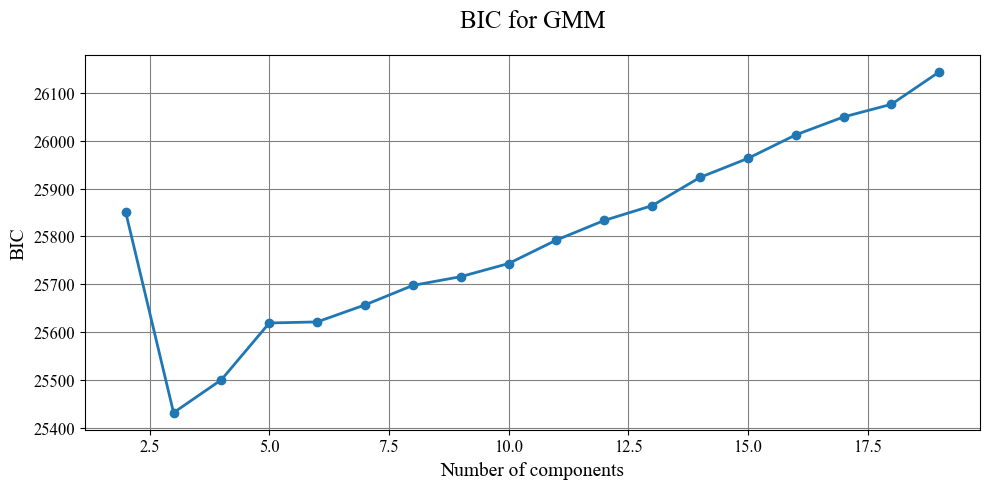

In [106]:
n_clusters, bic = Gauss_peaks(X, 2, 20, True)

In [108]:
from astroML.density_estimation import XDGMM

In [114]:
xdgmm = XDGMM(n_components=n_clusters, verbose=True, max_iter=100, tol=1e-1)

In [115]:
xdgmm.fit(X, Xerr)

c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


1: log(L) = -15500
    (1.9 sec)
2: log(L) = -15474
    (1.9 sec)
3: log(L) = -15457
    (1.9 sec)
4: log(L) = -15446
    (2.5 sec)
5: log(L) = -15436
    (1.9 sec)
6: log(L) = -15428
    (2 sec)
7: log(L) = -15420
    (2.2 sec)
8: log(L) = -15413
    (1.9 sec)
9: log(L) = -15407
    (2 sec)
10: log(L) = -15401
    (2.3 sec)
11: log(L) = -15396
    (2.1 sec)
12: log(L) = -15391
    (2 sec)
13: log(L) = -15386
    (3.4 sec)
14: log(L) = -15382
    (4.3 sec)
15: log(L) = -15378
    (6.9 sec)
16: log(L) = -15375
    (4.3 sec)
17: log(L) = -15372
    (3.4 sec)
18: log(L) = -15369
    (2.5 sec)
19: log(L) = -15367
    (1.9 sec)
20: log(L) = -15365
    (2.4 sec)
21: log(L) = -15363
    (2 sec)
22: log(L) = -15362
    (1.9 sec)
23: log(L) = -15361
    (1.9 sec)
24: log(L) = -15360
    (1.9 sec)
25: log(L) = -15359
    (1.9 sec)
26: log(L) = -15358
    (1.9 sec)
27: log(L) = -15357
    (1.9 sec)
28: log(L) = -15357
    (1.9 sec)
29: log(L) = -15357
    (1.8 sec)
30: log(L) = -15356
    (1.9 se

XDGMM(n_components=3, tol=0.1, verbose=True)

In [116]:
xdgmm.logL(X, Xerr)

np.float64(-15355.31116795864)

In [117]:
xdgmm.logprob_a(X,Xerr)

array([[ -2.63102384,  -8.04633182,  -1.1912391 ],
       [ -2.80122956, -14.805389  ,  -5.21907212],
       [ -3.02219904,  -6.88131826,  -1.24827898],
       ...,
       [ -8.20125633,  -4.8506504 ,  -8.32235611],
       [ -7.97877339, -25.94283379, -16.85185656],
       [ -3.30001178,  -8.73190758,  -2.68923351]])

In [122]:
X_new = xdgmm.sample(X.shape[0])

In [123]:
import matplotlib.pyplot as plt

In [124]:
from matplotlib.patches import Ellipse

def plot_gmm_ellipses(means, covs, ax=None, n_std=2.0, **kwargs):
    if ax is None:
        ax = plt.gca()
    for mean, cov in zip(means, covs):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        width, height = 2 * n_std * np.sqrt(vals)
        ellipse = Ellipse(xy=mean, width=width, height=height,
                          angle=theta, edgecolor='black', facecolor='none', lw=3, **kwargs)
        ax.add_patch(ellipse)

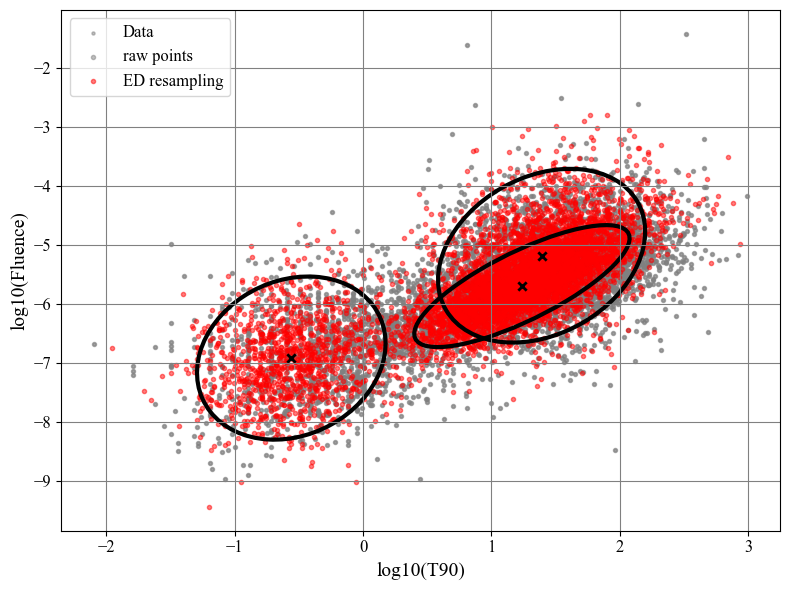

In [135]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(T90, fluence, s=5, c='gray', alpha=0.5, label='Data')
ax.scatter(X.T[0],X.T[1],marker='.',color='gray', alpha=0.5,label='raw points')
ax.scatter(X_new.T[0],X_new.T[1], marker='.', color='red', alpha=0.5, label='ED resampling')
plot_gmm_ellipses(xdgmm.mu, xdgmm.V, ax=ax)
for centroid in xdgmm.mu:
    plt.scatter(centroid[0], centroid[1], marker='x', color='black')
plt.legend()
ax.set_xlabel("log10(T90)")
ax.set_ylabel("log10(Fluence)")
ax.legend()
plt.show()

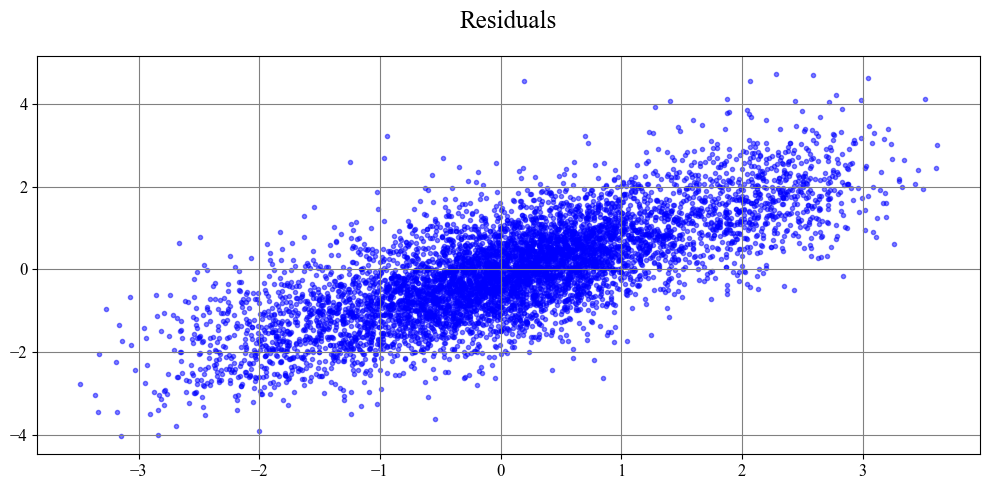

In [130]:
plt.title('Residuals')
plt.scatter(X.T[0]-X_new.T[0],X.T[1]-X_new.T[1], marker='.', color='blue', alpha=0.5)

In [131]:
xdgmm.V

array([[[0.16265965, 0.08246761],
        [0.08246761, 0.54338497]],

       [[0.13477425, 0.04561462],
        [0.04561462, 0.47906213]],

       [[0.17582059, 0.16982284],
        [0.16982284, 0.26788112]]])